Find more than 3 values of sigma

In [2]:
import numpy as np
from scipy.integrate import odeint
from solveTmu import blackness

from timebudget import timebudget

import matplotlib.pyplot as plt
from multiprocess import Pool
import os
import pandas as pd 
from criticalZoom import chiral


In [7]:
numsigmas=1 # maximum number of solutions we're looking for (global)

tmin=60
tmax=120
numtemp=50



#light quark mass
ml=0

#chemical potential
mu=0

lambda1= 7.438 #parameter for mixing between dilaton and chiral field

minsigma=5
maxsigma=500

a0=0. 

temps,sigmas=sigma_values(tmin,tmax,numtemp,minsigma,maxsigma, ml, mu, lambda1,a0) 

/usr/local/lib64/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib64/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib64/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib64/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/l

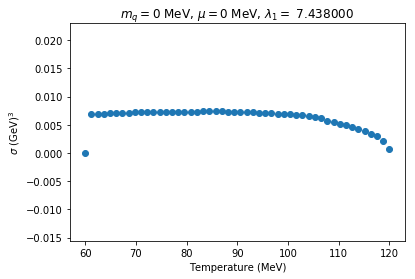

In [8]:
#plot all the sigma values for each iteration
#get the standard colors for matplotlib
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#find the index of when sigma_list[0][:,0] has its first zero value
#this is the index of the first temperature where the sigma value is zero


for i in range(0,numsigmas):
    plt.scatter(temps,(sigmas[:,i]/1000)**3,color=colors[i])


# plt.scatter(oldtemps,(oldsigmas[:,0]/1000)**3,color=colors[3])
# plt.scatter(oldtemps,(oldsigmas[:,1]/1000)**3,color=colors[4])
# plt.scatter(oldtemps,(oldsigmas[:,2]/1000)**3,color=colors[5])
plt.xlabel("Temperature (MeV)")
plt.ylabel("$\sigma$ (GeV)$^3$")
#set the x range
#plt.xlim(temps_list[0][0],max_temp)
# plt.ylim([np.amin((1.05*oldsigmas[:,0]/1000))**3,np.amax((1.05*oldsigmas[:,2]/1000))**3])
plt.title(r'$m_q=%i$ MeV, $\mu=%i$ MeV, $\lambda_1=$ %f' %(ml,mu,lambda1))
# plt.savefig("plots/sigma_T_mq%i_mu%i_lambda_%f_weird.png" %(ml,mu,lambda1))
plt.show()

In [161]:
sigmas

array([[  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [277.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [280.]])

In [152]:
oldsigmas=sigmas
oldtemps=temps

In [1]:
def allSigmas(args):#,mu,ml,minsigma,maxsigma,a0,lambda1):
    "Unpack the input"
    T,mu,ml,minsigma,maxsigma,a0,lambda1=args

    minsigma=int(minsigma)
    maxsigma=int(maxsigma)
    
    mu_g=440

    "solve for horizon and charge"
    zh,q=blackness(T,mu)
    Q=q*zh**3
    """
    limits of spatial variable z/zh. Should be close to 0 and 1, but 
    cannot go all the way to 0 or 1 because functions diverge there
    """
    ui = 1e-4 #0.01
    uf = 1-ui
    "Create the spatial variable mesh"
    umesh=100
    u=np.linspace(ui,uf,umesh)
    

    
    
 
    
    "This is a constant that goes into the boundary conditions"
    zeta=np.sqrt(3)/(2*np.pi)
    
    "For the scalar potential in the action"
    "see papers by Bartz, Jacobson"
    #v3= -3 #only needed for 2+1 flavor
    # v4 = 8
    # v3 = -3
    
    "Matching Fang paper"
    v4=4.2
    v3= 0#-22.6/(6*np.sqrt(2))
    
    "need the dilaton for mixing term in test function"
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
        
    #sigmal=260**3
    params=v3,v4,lambda1,mu_g,a0,zh,q
    "blackness function and its derivative, Reissner-Nordstrom metric"
    "This version is for finite temp, finite chemical potential"
    f = 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp = -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    
    "stepsize for search over sigma"
    "Note: search should be done over cube root of sigma, here called sl"
    if np.abs(maxsigma-minsigma)<10:
        deltasig = 0.1
    else:
        deltasig = 1
        
    if minsigma>maxsigma:
        deltasig=-deltasig
        
    #tic = time.perf_counter()

    # create an array of sigma values from minsigma to maxsigma, incrementing by deltasig
    sigmavalues = np.arange(minsigma,maxsigma,deltasig)

    truesigma = 0
    "This version steps over all values to find multiple solutions at some temps"
    
    "initial values for comparing test function"
    oldtest=0
    j=0
    truesigma=np.zeros(numsigmas)
    
    
    s2=-3*(ml*zeta)**2*v3
    s3=-9*(zeta*ml)**3*v3**2 + 2*(zeta*ml)**3*v4 + ml*zeta*mu_g**2 - 1/2*ml*zeta*lambda1*mu_g**2

    #for sl in range (minsigma,maxsigma,deltasig):
    for i in range(len(sigmavalues)):
        sl=sigmavalues[i]
        "values for chiral field and derivative at UV boundary"
        sigmal = sl**3
        UVbound = [ml*zeta*zh*ui + sigmal/zeta*(zh*ui)**3+s2*(zh*ui)**2+s3*(zh*ui)**3*np.log(zh*ui), 
                   ml*zeta*zh + 3*sigmal/zeta*zh**3*ui**2 + 2*s2*zh**2*ui + s3* ui**2*zh**3*(1+3*np.log(zh*ui))]
           
        "solve for the chiral field"
        chiFields=odeint(chiral,UVbound,u,args=(params,))
        
        "test function defined to find when the chiral field doesn't diverge"
        "When test function is zero at uf, the chiral field doesn't diverge"
        test = ((-u**2*fp)/f)*chiFields[:,1]-1/f*(3*chiFields[:,0]+lambda1*phi*chiFields[:,0]-3*v3*chiFields[:,0]**2-4*v4*chiFields[:,0]**3)
        testIR = test[umesh-1]#value of test function at uf
        
        "when test function crosses zero, it will go from + to -, or vice versa"
        "This is checked by multiplying by value from previous value of sigma"
        if oldtest*testIR<0: #and chiFields[umesh-1,0]>0:
           
            truesigma[j]=sl #save this value
            j=j+1 #if there are other sigma values, they will be stored also
            #print(truesigma)
        if j>numsigmas-1:
            break
            
        oldtest=testIR

    
    return truesigma

def get_all_sigmas_parallel(operation,input,pool):
    truesigma=np.zeros([len(input),numsigmas])

    truesigma=pool.map(operation, input)
    
    return truesigma

def sigma_values(tmin,tmax,numtemp,minsigma,maxsigma, ml, mu, lambda1,a0):

    temps=np.linspace(tmin,tmax,numtemp)
    lambda1 = lambda1*np.ones(numtemp)
    ml = ml*np.ones(numtemp)
    mu = mu*np.ones(numtemp)
    a0 = a0*np.ones(numtemp)

    minsigma=minsigma*np.ones(numtemp)
    maxsigma=maxsigma*np.ones(numtemp)

    tempsArgs=np.array([temps,mu,ml,minsigma,maxsigma,a0,lambda1]).T


    #need up to 3 sigma values per temperature
    # truesigma=np.zeros([numtemp,3])
    
    "This calls the old version, which loops over all temps. Only un-comment for speed comparisons"
    # truesigma=get_all_sigmas(allSigmas,tempsArgs)
    
    "Create a pool that uses all available cpus"
    processes_count=os.cpu_count()    
    processes_pool = Pool(processes_count)
    
    truesigma=get_all_sigmas_parallel(allSigmas,tempsArgs,processes_pool)
    truesigma=np.array(truesigma)
    processes_pool.close()
    
    return temps, truesigma